In [1]:
import os
print(os.getcwd())
os.chdir("..")


/home/icb/florin.ratajczak/ppi-core-genes/speos


In [2]:
from speos.utils.config import Config
from speos.pipeline import InferencePipeline
from speos.explanation import MessagePassingExplainer
from speos.models import ModelBootstrapper
from speos.datasets import DatasetBootstrapper
from speos.preprocessing.mappers import GWASMapper, AdjacencyMapper

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
config = Config()
config.parse_yaml("configs/config_immune_dysregulation_film_forreal.yaml")

In [4]:
pre_mappings = pre_mappings = GWASMapper().get_mappings(config.input.tag, fields=config.input.field)

mappings = []

for mapping in pre_mappings:
    if not "AMD" in mapping["name"]:
        mappings.append(mapping)

adjacencies = AdjacencyMapper(config.input.adjacency_mappings, blacklist=config.input.adjacency_blacklist).get_mappings(config.input.adjacency, fields=config.input.adjacency_field)

dataset = DatasetBootstrapper(mappings, adjacencies, holdout_size=config.input.holdout_size, name="test", config=config).get_dataset()

node_data = dataset.data
input_dim = node_data.x.shape[1]

model = ModelBootstrapper(
            config, input_dim, len(adjacencies)).get_model()

immune_dysregulation_film_forreal 2022-12-17 16:40:49,587 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['BioPlex30HCT116', 'BioPlex30293T', 'HuRI', 'IntActPA', 'IntActDirect', 'hetionetregulates', 'hetionetcovaries', 'GRNDBadiposetissue', 'GRNDBadrenalgland', 'GRNDBbloodx', 'GRNDBbloodvessel', 'GRNDBbrain', 'GRNDBbreast', 'GRNDBcolon', 'GRNDBesophagus', 'GRNDBheart', 'GRNDBkidney', 'GRNDBliver', 'GRNDBlung', 'GRNDBmuscle', 'GRNDBnerve', 'GRNDBovary', 'GRNDBpancreas', 'GRNDBpituitary', 'GRNDBprostate', 'GRNDBsalivarygland', 'GRNDBskin', 'GRNDBsmallintestine', 'GRNDBspleen', 'GRNDBstomach', 'GRNDBtestis', 'GRNDBthyroid', 'GRNDButerus', 'GRNDBvagina']
immune_dysregulation_film_forreal 2022-12-17 16:40:49,587 [INFO] speos.preprocessing.preprocessor: Using 7 mappings with ground truth data/mendelian_gene_sets/Immune_Dysregulation_genes.bed 
immune_dysregulation_film_forreal 2022-12-17 16:40:49,826 [INFO] speos.datasets: Loading Processed Data from ./data/processed/immu

In [5]:
config.name = "immune_dysregulation_film_forreal_outer_0_fold_1"

In [6]:
from speos.helpers import CheckPointer
checkpointer = CheckPointer(
                model, config.model.save_dir + config.name, mode=config.es.mode)

In [9]:
model.architectures[0].double()

RelationalGeneNetwork(
  (pre_mp): Sequential(
    (0): Linear(93, 50, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(50, 50, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(50, 50, bias=True)
    (5): ELU(alpha=1.0)
  )
  (post_mp): Sequential(
    (0): Linear(50, 50, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(50, 50, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(50, 25, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(25, 1, bias=True)
  )
  (mp): Sequential(
    (0): FiLMConv(50, 50, num_relations=34)
    (1): ELU(alpha=1.0)
    (2): InstanceNorm(50)
    (3): FiLMConv(50, 50, num_relations=34)
    (4): ELU(alpha=1.0)
    (5): InstanceNorm(50)
  )
)

In [10]:
val_out, loss = model.step(
                dataset.data, dataset.data.val_mask, eval_flag=True)

print(val_out)

tensor([[-0.0597, -0.0769, -0.0735,  ..., -0.0679, -0.0620, -0.0644]],
       dtype=torch.float64, grad_fn=<ViewBackward>)


In [11]:
checkpointer.restore()

(88, 0.3722697056030213)

In [12]:
val_out, loss = model.step(
                dataset.data, dataset.data.val_mask, eval_flag=True)

print(val_out)

tensor([[-8.6794, -8.2211, -4.3948,  ..., -8.7851, -7.1715, -1.5089]],
       dtype=torch.float64, grad_fn=<ViewBackward>)


In [13]:
adjacency_names = [adjacency["name"] for adjacency in adjacencies]

In [14]:
model.architectures[0] = model.architectures[0].double()

mpex =  MessagePassingExplainer(model, dataset.data, adjacency_names, config)

# Check the gamma to beta ratio

In [17]:
latent_node_features = mpex.get_latent_features()

In [22]:
from torch_sparse import SparseTensor, masked_select_nnz
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
%matplotlib inline


latent_node_features = mpex.get_latent_features()

factors_raw = [[],[]]
for layernum, layer in enumerate([model.architectures[0].mp[0], model.architectures[0].mp[3]]):
    factors = []
    for i in range(len(adjacency_names) + 1):
        beta, gamma = mpex.get_beta_gamma(latent_node_features, layer, i)
        factor = (gamma/beta).detach().abs().numpy()
        factors_raw[layernum].append(factor.flatten())
        factors.append(np.mean(factor).item())
    print(factors)
    latent_node_features = model.architectures[0].mp[0](latent_node_features, edge_index)
    latent_node_features = model.architectures[0].mp[1](latent_node_features)
    latent_node_features = model.architectures[0].mp[2](latent_node_features)

latent_node_features = mpex.get_latent_features()

[7.060298271860865, 8.71358777799497, 7.5444549200010975, 8.018916799147382, 19.60672659543765, 10.265562355543551, 9.855899462611873, 11.673702344990438, 12.12243315259805, 11.088956821567438, 11.29076326844477, 7.962983418481383, 10.309940977269179, 7.59000066640927, 7.449124701103718, 8.639547440158763, 10.230834797423174, 9.072389173232429, 15.980000944106438, 7.221301077073394, 8.112729274867709, 7.6032214936184594, 9.280627287340643, 10.04498423168928, 7.457503378975848, 8.002207741118806, 9.585178896805752, 8.62378995653413, 8.350867805469505, 10.43981778483482, 33.5214213706184, 10.485437264471093, 102.93764778910952, 12.045174187366937, 9.4631639521386]
[7.083478957257183, 8.04516766449814, 8.821018975134747, 8.872194644421924, 6.362612870161428, 11.205314988887002, 7.897921685252603, 10.216012008137671, 6.777783953897734, 11.691586146378963, 11.964432427477742, 8.733657279358976, 7.80810856938539, 9.066776176479145, 6.309313153208837, 11.207226825533253, 13.4081269275261, 12.

In [26]:
factor.shape[0] * factor.shape[1]

851200

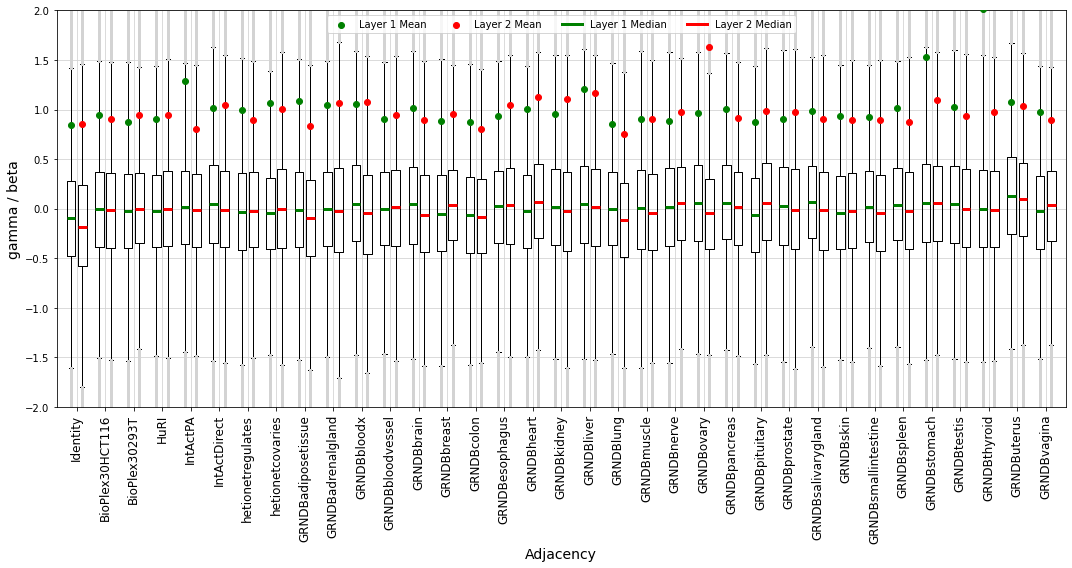

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))

patches = []

for layernum in [0,1]:
    x = np.arange(len(factors_raw[layernum]))
    bp = ax.boxplot([np.log10(array) for array in factors_raw[layernum]], positions=(x - 0.2) + (0.4 * layernum), widths=0.3,
                    flierprops={'marker': 'x', 'markersize': 2, 'markeredgecolor': 'lightgray'})
    for median in bp['medians']:
        median.set(color ='green' if layernum == 0 else "red",
        linewidth=3, solid_capstyle="butt")
    for artist in bp['boxes']:
        patch = mpatches.PathPatch(artist.get_path(), color="white")
        ax.add_artist(patch)
    patches.append(ax.scatter((x - 0.2) + (0.4 * layernum), [np.log10(np.mean(array)) for array in factors_raw[layernum]], color ='green' if layernum == 0 else "red", zorder= 10))

ax.set_ylim((-2, 2))
#ax.set_yticks(np.arange(16) -6, [str(number) for number in np.arange(16) -6], fontsize=12)
ax.grid(True, color="lightgray")
ax.set_xticks(x, ["Identity"] + adjacency_names, fontsize=12)
ax.set_xlabel("Adjacency", fontsize=14)
ax.set_ylabel("gamma / beta", fontsize=14)
fig.autofmt_xdate(rotation=90, ha="center")

patches.extend([Line2D([0], [0], color="green", lw=3),
                Line2D([0], [0], color="red", lw=3)])

plt.legend(patches, ["Layer 1 Mean", "Layer 2 Mean", "Layer 1 Median", "Layer 2 Median"],loc="upper center", ncol=len(patches))
plt.tight_layout()

In [20]:
from speos.utils.nn_utils import typed_edges_to_sparse_tensor

edge_index, encoder = typed_edges_to_sparse_tensor(dataset.data.x, dataset.data.edge_index_dict)

In [37]:
middle_mp_latent_node_features = model.architectures[0].mp[0](latent_node_features, edge_index)
middle_mp_latent_node_features = model.architectures[0].mp[1](middle_mp_latent_node_features)
middle_mp_latent_node_features = model.architectures[0].mp[2](middle_mp_latent_node_features)

In [21]:
for i in range(len(adjacency_names) + 1):
    beta, gamma = mpex.get_beta_gamma(middle_mp_latent_node_features, model.architectures[0].mp[3], i)
    factor = (gamma/beta).abs().sum() / (gamma.shape[0] * gamma.shape[1])
    print("{}: {}".format("Identity" if i == 0 else adjacency_names[i-1], factor))

NameError: name 'middle_mp_latent_node_features' is not defined

### As we have expected, gamma is much higher than beta. Thus, we only have to ascertain how the sender's message factors into this

In [22]:
from torch_sparse import SparseTensor, masked_select_nnz
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
%matplotlib inline


adjacencies = encoder.inverse_transform(torch.unique(edge_index.storage.value()).long())

df = pd.DataFrame(index = adjacencies.tolist())


latent_node_features = mpex.get_latent_features()



factors_raw = [[],[]]
for layernum, layer in enumerate([model.architectures[0].mp[0], model.architectures[0].mp[3]]):
    factors = []
    for i in range(len(adjacencies)):
        beta, gamma = mpex.get_beta_gamma(latent_node_features, layer, i + 1)
        
        lin = layer.lins[i]

        edge_type = edge_index.storage.value()
        assert edge_type is not None
        mask = edge_type == i 
        masked_edge_index = masked_select_nnz(edge_index, mask, layout='coo')

        senders_message = lin(latent_node_features[masked_edge_index.storage.row(), :])
        receiver_gamma = gamma[masked_edge_index.storage.col(), :]
        receiver_beta = beta[masked_edge_index.storage.col(), :]

        #factor = (receiver_gamma/(senders_message * receiver_beta)).abs().sum() / (gamma.shape[0] * gamma.shape[1])

        factor = (((senders_message * receiver_beta) / receiver_gamma)).detach().abs().numpy()
        #factor = factor / ((senders_message * receiver_beta) + receiver_gamma).detach().abs().numpy()
        #factor = ((((senders_message * receiver_gamma) / receiver_beta) * (senders_message / receiver_gamma)) / senders_message.abs()).detach().abs().numpy()
        factors_raw[layernum].append(factor.flatten())
        factors.append(np.median(factor).item())
        #print("{}: {}".format("Identity" if i == 0 else adjacency_names[i-1], factor))
    df["Layer {}".format(layernum)] = factors

    latent_node_features = model.architectures[0].mp[0](latent_node_features, edge_index)
    latent_node_features = model.architectures[0].mp[1](latent_node_features)
    latent_node_features = model.architectures[0].mp[2](latent_node_features)

latent_node_features = mpex.get_latent_features()
print(df)

                      Layer 0   Layer 1
BioPlex30293T        0.103280  0.094736
BioPlex30HCT116      0.126973  0.072022
GRNDBadiposetissue   0.113403  0.694666
GRNDBadrenalgland    0.098036  0.653938
GRNDBbloodvessel     0.096195  0.772207
GRNDBbloodx          0.100195  0.555391
GRNDBbrain           0.098100  0.533155
GRNDBbreast          0.091735  0.578475
GRNDBcolon           0.114412  0.612393
GRNDBesophagus       0.096473  0.609067
GRNDBheart           0.105019  0.520020
GRNDBkidney          0.104797  0.512127
GRNDBliver           0.114014  0.719740
GRNDBlung            0.104456  0.739172
GRNDBmuscle          0.100743  0.587165
GRNDBnerve           0.087702  0.628843
GRNDBovary           0.099834  0.525339
GRNDBpancreas        0.100836  0.622521
GRNDBpituitary       0.093991  0.788705
GRNDBprostate        0.092567  0.601338
GRNDBsalivarygland   0.102044  0.587307
GRNDBskin            0.087657  0.484121
GRNDBsmallintestine  0.098700  0.624748
GRNDBspleen          0.110079  0.568722


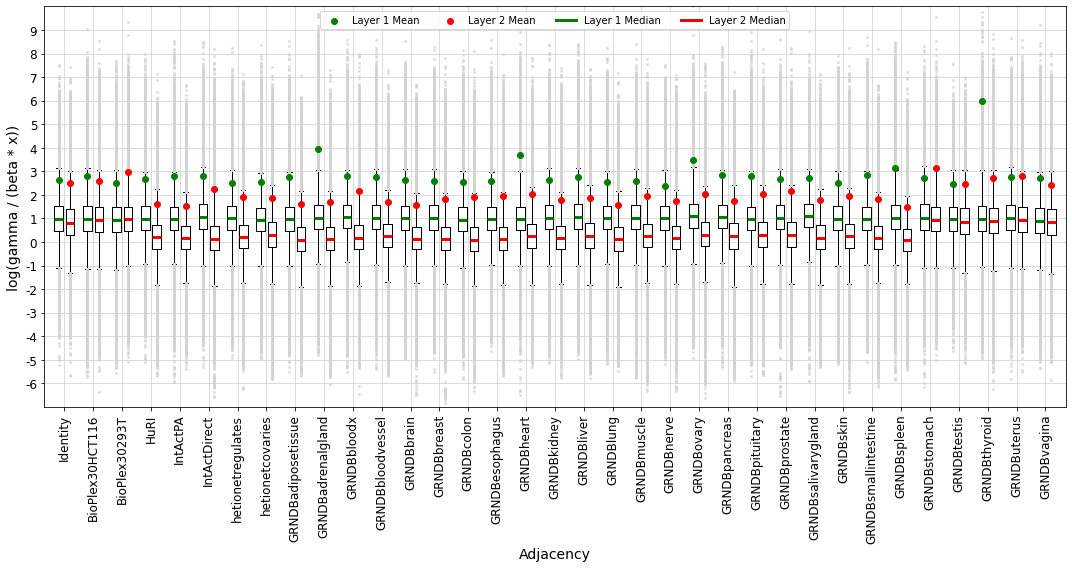

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))

patches = []

for layernum in [0,1]:
    x = np.arange(len(factors_raw[layernum]))
    bp = ax.boxplot([np.log10(array) for array in factors_raw[layernum]], positions=(x - 0.2) + (0.4 * layernum), widths=0.3,
                    flierprops={'marker': 'x', 'markersize': 2, 'markeredgecolor': 'lightgray'})
    for median in bp['medians']:
        median.set(color ='green' if layernum == 0 else "red",
        linewidth=3, solid_capstyle="butt")
    for artist in bp['boxes']:
        patch = mpatches.PathPatch(artist.get_path(), color="white")
        ax.add_artist(patch)
    patches.append(ax.scatter((x - 0.2) + (0.4 * layernum), [np.log10(np.mean(array)) for array in factors_raw[layernum]], color ='green' if layernum == 0 else "red", zorder= 10))

ax.set_ylim((-7, 10))
ax.set_yticks(np.arange(16) -6, [str(number) for number in np.arange(16) -6], fontsize=12)
ax.grid(True, color="lightgray")
ax.set_xticks(x, adjacency_names, fontsize=12)
ax.set_xlabel("Adjacency", fontsize=14)
ax.set_ylabel("log(gamma / (beta * x))", fontsize=14)
fig.autofmt_xdate(rotation=90, ha="center")

patches.extend([Line2D([0], [0], color="green", lw=3),
                Line2D([0], [0], color="red", lw=3)])

plt.legend(patches, ["Layer 1 Mean", "Layer 2 Mean", "Layer 1 Median", "Layer 2 Median"],loc="upper center", ncol=len(patches))
plt.tight_layout()

#plt.savefig("gamma_beta.pdf", bbox_inches="tight")

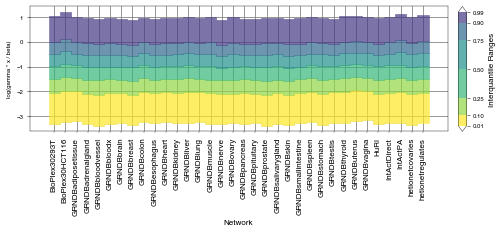

In [30]:

gs_kw = dict(width_ratios=[1,0.02])
from speos.visualization.settings import *
import matplotlib.pyplot as plt

fig, (ax, ax2) = plt.subplots(1,2, figsize=(full_width*cm, (17*cm)/2), gridspec_kw=gs_kw)

import numpy as np
from matplotlib import cm
import matplotlib as mpl
from numpy import linspace

patches = []


start = 0.0
stop = 1.0
number_of_lines = 7
alpha = 0.7
cm_subsection = linspace(stop, start, number_of_lines)
colors = [cm.viridis(x) for x in cm_subsection]
colors = [color[:3] + (alpha,) for color in colors]

for layernum in [0]:
    x = np.arange(len(factors_raw[layernum]))

    factors_transformed = [np.log10(array) for array in factors_raw[layernum]]
    q001_, q01_, q25_, q50_, q75_, q90_, q99_ = [[np.quantile(_factors, k) for  _factors in factors_transformed] for k in [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]]

    steps = []
    steps.append(ax.step(y=q001_, x =x-0.5, where = "post", c="lightgray",zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q01_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q25_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q50_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q75_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q90_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q99_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])

    for i in range(1, len(steps)):
        ax.fill_between(x=[value-0.5 if index %2 == 0 else value+0.5 for index, value in enumerate(np.repeat(x,2))], 
                        y1=np.repeat(steps[i-1].get_ydata(), 2), 
                        y2=np.repeat(steps[i].get_ydata(), 2), zorder=5,
                        linewidth=0.5,
                        color =colors[i-1])


#ax.set_ylim((-7, 10))
#ax.set_yticks(np.arange(16) -6, [str(number) for number in np.arange(16) -6], fontsize=12)
ax.grid(True, color="gray", zorder = -1)
ax.set_xticks(x, adjacencies.tolist(), fontsize=medium_font)
ax.set_xlabel("Network", fontsize=medium_font)
ax.set_ylabel("log(gamma * x / beta)", fontsize=small_font)
fig.autofmt_xdate(rotation=90, ha="center")

cmap = (mpl.colors.ListedColormap(colors[:len(steps)-1]).with_extremes(over='white', under='white'))


bounds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='both',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',
    label="Interquantile Ranges"
)

#cbar.ax.set_xticklabels([".01", ".1", ".25", ".5", ".75", ".9",".99"]) 
cbar.ax.tick_params(labelsize=small_font)
cbar.set_label(label="Interquantile Ranges", fontsize=medium_font)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)

plt.savefig("gamma_delta_1_2.svg", bbox_inches="tight")

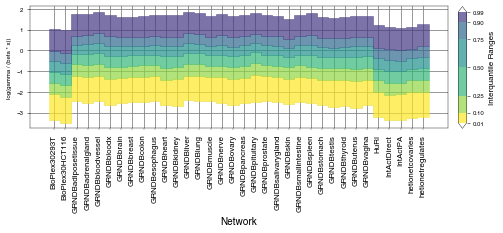

In [31]:
gs_kw = dict(width_ratios=[1,0.02])

from speos.visualization.settings import *
import matplotlib.pyplot as plt

fig, (ax, ax2) = plt.subplots(1,2, figsize=(full_width*cm, (17*cm)/2), gridspec_kw=gs_kw)

import numpy as np
from matplotlib import cm
import matplotlib as mpl
from numpy import linspace

patches = []


start = 0.0
stop = 1.0
number_of_lines = 7
alpha = 0.7
cm_subsection = linspace(stop, start, number_of_lines)
colors = [cm.viridis(x) for x in cm_subsection]
colors = [color[:3] + (alpha,) for color in colors]

for layernum in [1]:
    x = np.arange(len(factors_raw[layernum]))

    factors_transformed = [np.log10(array) for array in factors_raw[layernum]]
    q001_, q01_, q25_, q50_, q75_, q90_, q99_ = [[np.quantile(_factors, k) for  _factors in factors_transformed] for k in [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]]

    steps = []
    steps.append(ax.step(y=q001_, x =x-0.5, where = "post", c="lightgray",zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q01_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q25_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q50_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q75_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q90_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])
    steps.append(ax.step(y=q99_, x =x-0.5, where = "post", c="lightgray", zorder=-1, linewidth=0.5)[0])

    for i in range(1, len(steps)):
        ax.fill_between(x=[value-0.5 if index %2 == 0 else value+0.5 for index, value in enumerate(np.repeat(x,2))], 
                        y1=np.repeat(steps[i-1].get_ydata(), 2), 
                        y2=np.repeat(steps[i].get_ydata(), 2), zorder=5,
                        linewidth=0.5,
                        color =colors[i-1])


#ax.set_ylim((-7, 10))
#ax.set_yticks(np.arange(16) -6, [str(number) for number in np.arange(16) -6], fontsize=12)
ax.grid(True, color="gray", zorder = -1)
ax.set_xticks(x, adjacencies.tolist(), fontsize=medium_font)
ax.set_xlabel("Network", fontsize=large_font)
ax.set_ylabel("log(gamma / (beta * x))", fontsize=small_font)
fig.autofmt_xdate(rotation=90, ha="center")

cmap = (mpl.colors.ListedColormap(colors[:len(steps)-1]).with_extremes(over='white', under='white'))


bounds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='both',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',
    label="Interquantile Ranges"
)

#cbar.ax.set_xticklabels([".01", ".1", ".25", ".5", ".75", ".9",".99"]) 
cbar.ax.tick_params(labelsize=small_font)
cbar.set_label(label="Interquantile Ranges", fontsize=medium_font)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)

plt.savefig("gamma_delta_2_2.svg", bbox_inches="tight")

# Trying to tease it apart for nodes TNFSF15 and IL18RAP

In [76]:
from torch_sparse import SparseTensor, masked_select_nnz
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
%matplotlib inline

node_id = 6749 #  15145    #

adjacencies = encoder.inverse_transform(torch.unique(edge_index.storage.value()).long())

df = pd.DataFrame(index = ["Identity"] + adjacencies.tolist())

latent_node_features = mpex.get_latent_features()



factors_raw = [[],[]]
messages_raw = [[],[]]
gammas_raw = [[],[]]
betas_raw = [[],[]]
final_messages = [[],[]]
for layernum, layer in enumerate([model.architectures[0].mp[0], model.architectures[0].mp[3]]):
    factors = []
    for i in range(len(adjacencies) + 1):
        beta, gamma = mpex.get_beta_gamma(latent_node_features, layer, i)
        if i == 0:
            lin = layer.lin_skip
        else:
            lin = layer.lins[i - 1]

        if i == 0:
            masked_edge_index = torch.LongTensor((range(latent_node_features.shape[0]), range(latent_node_features.shape[0])))

            senders_message = lin(latent_node_features[masked_edge_index[0, node_id], :])
            receiver_gamma = gamma[masked_edge_index[1, node_id], :]
            receiver_beta = beta[masked_edge_index[1, node_id], :]

        else:
            edge_type = edge_index.storage.value()
            assert edge_type is not None
            mask = edge_type == i - 1
            masked_edge_index = masked_select_nnz(edge_index, mask, layout='coo')

            senders_message = lin(latent_node_features[masked_edge_index[:, node_id].storage.row(), :])
            receiver_gamma = gamma[node_id, :]
            receiver_beta = beta[node_id, :]

        messages_raw[layernum].append(senders_message)
        gammas_raw[layernum].append(receiver_gamma)
        betas_raw[layernum].append(receiver_beta)
        final_messages[layernum].append((receiver_beta * senders_message) +  receiver_gamma)


        #factor = (receiver_gamma/(senders_message * receiver_beta)).abs().sum() / (gamma.shape[0] * gamma.shape[1])
        factor = (((senders_message * receiver_beta) / receiver_gamma)).detach().abs().numpy()
        #factor = (receiver_gamma/(senders_message * receiver_beta)).detach().abs().numpy()
        factors_raw[layernum].append(factor)
        factors.append(np.median(factor).item())
        #print("{}: {}".format("Identity" if i == 0 else adjacency_names[i-1], factor))
    df["Layer {}".format(layernum)] = factors

    latent_node_features = model.architectures[0].mp[0](latent_node_features, edge_index)
    latent_node_features = model.architectures[0].mp[1](latent_node_features)
    latent_node_features = model.architectures[0].mp[2](latent_node_features)

latent_node_features = mpex.get_latent_features()
print(df)

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


                      Layer 0   Layer 1
Identity             0.177840  0.113986
BioPlex30293T        0.063132  0.074010
BioPlex30HCT116           NaN       NaN
GRNDBadiposetissue   0.153788  0.712017
GRNDBadrenalgland    0.079235  0.706244
GRNDBbloodvessel     0.109531  0.861124
GRNDBbloodx          0.133290  0.866432
GRNDBbrain           0.144708  0.677745
GRNDBbreast          0.082641  0.662819
GRNDBcolon           0.156742  0.804638
GRNDBesophagus       0.207393  0.667815
GRNDBheart           0.111400  0.404736
GRNDBkidney          0.167045  0.586322
GRNDBliver           0.115708  0.957475
GRNDBlung            0.067541  1.231776
GRNDBmuscle          0.138812  0.635859
GRNDBnerve           0.127941  0.621217
GRNDBovary           0.145475  0.457737
GRNDBpancreas        0.137207  0.923731
GRNDBpituitary       0.092904  0.661941
GRNDBprostate        0.156420  0.886920
GRNDBsalivarygland   0.163421  0.585552
GRNDBskin            0.115798  0.454937
GRNDBsmallintestine  0.163058  0.884615


In [79]:
by_adjacency = {}

for adj, edges in zip(adjacencies.tolist(), (factors_raw[1][1:])):
    by_adjacency.update({adj:  np.median(edges, axis=1)})

In [80]:
for i, (key, values) in enumerate(by_adjacency.items()):
    if len(values) == 0:
        continue
    edge_type = edge_index.storage.value()
    mask = edge_type == i
    masked_edge_index = masked_select_nnz(edge_index, mask, layout='coo')
    print(key)
    print(masked_edge_index[:, node_id].storage.row())
    print(values)

BioPlex30293T
tensor([10725])
[0.07401009]
GRNDBadiposetissue
tensor([ 1352,  2519,  5242,  8123, 12014])
[0.60863947 1.00591378 0.69418557 0.42994393 1.02609901]
GRNDBadrenalgland
tensor([ 1084,  1352,  2519,  4600,  4669,  4676,  5241,  9339, 12015, 12016,
        12538, 14544])
[0.98706881 0.72342239 0.85252906 0.62363521 0.50873335 0.5617957
 0.45940043 0.96116256 0.87331154 0.51168216 0.66784927 0.51413582]
GRNDBbloodvessel
tensor([ 1352,  3277,  4422,  4668,  4675,  5186,  5241,  6693,  6903,  6910,
         6912,  6913,  8973,  9339, 11262, 13865])
[0.68677179 0.81395189 0.49002234 0.95291935 0.80145776 0.9796949
 0.5733443  1.0578989  1.07004327 1.18972749 0.83680763 0.74471894
 0.77408338 1.0881111  0.97477284 1.71232782]
GRNDBbloodx
tensor([ 2520, 14367])
[1.04045268 0.68681259]
GRNDBbrain
tensor([ 5241,  5242,  6903,  6912,  8973,  9346, 14081, 14083])
[0.49797285 0.66393036 0.65622908 0.73710712 0.68912214 0.62241735
 0.71438831 0.69732911]
GRNDBbreast
tensor([ 1033,  1278,

In [64]:
masked_edge_index.t()[: ,node_id].storage.row()

tensor([  368,  1356,  1413,  1418,  1421,  1562,  2237,  2239,  2376,  2386,
         2451,  2984,  3201,  3347,  3976,  4501,  4755,  5007,  7067,  7293,
         7723,  8074,  8322,  8579,  8742,  8890,  8973,  9377,  9458,  9742,
         9759, 10266, 10298, 10301, 10350, 10434, 11056, 11167, 11212, 11330,
        11632, 12041, 12466, 12470, 12477, 13566, 13691, 14079, 14489, 14882,
        15222, 15588, 15653, 15825, 15893, 16180])

In [41]:


((masked_edge_index.storage.col() == 6749).nonzero(as_tuple=True)[0]).shape

torch.Size([0])

In [42]:
edge_type = edge_index.storage.value()
mask = edge_type == 31
masked_edge_index = masked_select_nnz(edge_index, mask, layout='coo')

In [44]:
masked_edge_index[6749] , masked_edge_index[:, 6749]

(SparseTensor(row=tensor([0, 0]),
              col=tensor([15376, 16177]),
              val=tensor([31., 31.]),
              size=(1, 17024), nnz=2, density=0.01%),
 SparseTensor(row=tensor([15376, 16177]),
              col=tensor([0, 0]),
              val=tensor([31., 31.]),
              size=(17024, 1), nnz=2, density=0.01%))

In [58]:
edge_type = edge_index.storage.value()
assert edge_type is not None
mask = edge_type == 5
masked_edge_index = masked_select_nnz(edge_index, mask, layout='coo')
latent_node_features[masked_edge_index[:, node_id].storage.row(), :]

tensor([[-0.1118,  0.4930,  0.0686,  0.3200,  0.8446, -0.2646, -0.4688, -0.5313,
         -0.2705, -0.5295,  0.4533,  0.3773,  0.4132,  0.5657, -0.0989,  0.2056,
          0.2215,  0.5015, -0.4256, -0.3067,  0.1171, -0.1244,  0.2596, -0.1175,
          0.0082,  0.7434, -0.3214, -0.6795, -0.7784,  0.6859, -0.4038,  0.1828,
          0.4443, -0.0373,  0.6045, -0.1358, -0.6109, -0.3447, -0.3790,  0.1934,
         -0.7711,  0.3052,  0.4259, -0.1005, -0.2196,  0.1579, -0.5225,  0.0540,
          1.2362,  0.4352],
        [-0.2310,  0.0315,  0.0860,  0.7370,  0.8090, -0.5071, -0.5609, -0.2026,
          0.0108,  0.3928, -0.0039, -0.3642,  0.6108,  0.8757, -0.4112,  0.0104,
          0.1001,  0.2695,  0.2164,  0.2796,  0.2437,  0.4070, -0.3198, -0.3914,
          0.0710,  0.4240, -0.1358, -0.5421, -0.2612, -0.0907, -0.6207,  0.0527,
         -0.0775, -0.1195, -0.2851, -0.4510, -0.0301, -0.0649, -0.3686,  0.0541,
         -0.5255, -0.2534, -0.1788,  0.0587, -0.5653,  0.7720,  0.3003,  0.1493,


In [57]:
masked_edge_index[:, node_id]

SparseTensor(row=tensor([ 2520, 14367]),
             col=tensor([0, 0]),
             val=tensor([5., 5.]),
             size=(17024, 1), nnz=2, density=0.01%)

(array([ 8436., 21033., 20855., 17063.,  9729.,  6691.,  4148.,  2299.,
         1797.,  1314.]),
 array([0.31587825, 0.48400427, 0.65213029, 0.82025631, 0.98838234,
        1.15650836, 1.32463438, 1.4927604 , 1.66088643, 1.82901245,
        1.99713847]),
 <BarContainer object of 10 artists>)

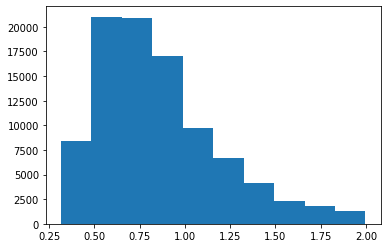

In [29]:
plt.hist(raw.detach().cpu().numpy()[raw.detach().cpu().numpy() < 2])

(array([12283., 31492., 17778., 10435.,  6852.,  4362.,  2869.,  2058.,
         1882.,  1865.]),
 array([0.5844143 , 0.72597193, 0.86752956, 1.00908719, 1.15064482,
        1.29220245, 1.43376008, 1.57531771, 1.71687534, 1.85843297,
        1.9999906 ]),
 <BarContainer object of 10 artists>)

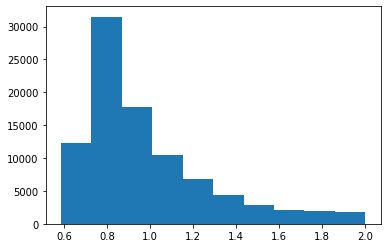

In [31]:
plt.hist(changed.detach().cpu().numpy()[changed.detach().cpu().numpy() < 2])

In [75]:
mpex.layer = 1
mpex.adjacency = 0

In [109]:
name, raw, changed = next(mpex.__next__())
factor = changed.detach().cpu().numpy() / raw.detach().cpu().numpy()
factor.mean()

2.3951314441138316

In [115]:
np.median(factor)

1.3805780375061825

In [73]:
factors = {}
for _ in adjacencies:
    name, raw, changed = next(mpex.__next__())
    factor = changed.detach().cpu().numpy() / raw.detach().cpu().numpy()
    factors[name] = factor.mean()

In [74]:
factors

{'Identity': 1.042396724524735,
 'BioPlex30HCT116': 2.229824234711957,
 'BioPlex30293T': 2.3951314441138316,
 'HuRI': 1.8515738903925167,
 'IntActPA': 1.3715504817499955,
 'IntActDirect': 1.8456550151805788,
 'hetionetregulates': 1.636977829383342,
 'hetionetcovaries': 1.7429185514987011,
 'GRNDBadiposetissue': 1.6265172700860597,
 'GRNDBadrenalgland': 1.7256925854694207,
 'GRNDBbloodx': 1.9000906005183167,
 'GRNDBbloodvessel': 1.5747445712534776,
 'GRNDBbrain': 1.7990473803461182,
 'GRNDBbreast': 1.4972500011774865,
 'GRNDBcolon': 1.6772023066944362,
 'GRNDBesophagus': 1.7761561685256546,
 'GRNDBheart': 1.7027031112091975,
 'GRNDBkidney': 1.7968691207986212,
 'GRNDBliver': 1.6444238505731124,
 'GRNDBlung': 1.6108668161069828,
 'GRNDBmuscle': 1.5811400592033074,
 'GRNDBnerve': 1.7243913508984139,
 'GRNDBovary': 1.915095359217609,
 'GRNDBpancreas': 1.6833342237959217,
 'GRNDBpituitary': 2.0060969670185163,
 'GRNDBprostate': 1.6883485914206697,
 'GRNDBsalivarygland': 1.9883496907235663,
